In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Завантажуємо вибірку

In [2]:
dataset = pd.read_csv('../Data/data_for_predictions.csv')

In [3]:
dataset

,Date,Open,Log,Log_Diff
0,2017-01-02,998.617004,6.906371,0.035635
1,2017-01-03,1021.599976,6.929125,0.022754
2,2017-01-04,1044.400024,6.951198,0.022073
3,2017-01-05,1156.729980,7.053352,0.102154
4,2017-01-06,1014.239990,6.921895,-0.131457
...,...,...,...,...
1773,2021-11-10,66953.335938,11.111751,-0.008868
1774,2021-11-11,64978.890625,11.081818,-0.029933
1775,2021-11-12,64863.980469,11.080048,-0.001770
1776,2021-11-13,64158.121094,11.069106,-0.010942


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1778 non-null   datetime64[ns]
 1   Open      1778 non-null   float64       
 2   Log       1778 non-null   float64       
 3   Log_Diff  1778 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 55.7 KB


In [6]:
dataset.set_index('Date', inplace = True)

In [7]:
dataset.shape

(1778, 3)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1778 entries, 2017-01-02 to 2021-11-14
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      1778 non-null   float64
 1   Log       1778 non-null   float64
 2   Log_Diff  1778 non-null   float64
dtypes: float64(3)
memory usage: 55.6 KB


### Будуємо графік функції і дивимось на перший погляд чи є сезонність і яка вона (адитивна чи мультиплікативна)

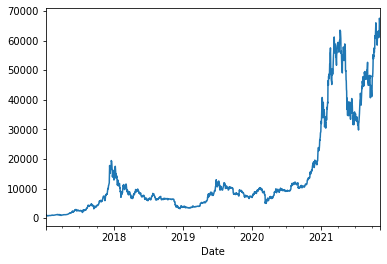

In [9]:
ax = dataset['Open'].plot()

In [ ]:
from itertools import product
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings('ignore')

#Set initial values and some bounds
ps = range(0, 2)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = int(365/7)

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    '''
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    '''
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(dataset['Log_Diff'], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(dataset['Log_Diff'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

In [25]:
prediction = best_model.forecast(365)

In [26]:
prediction

2021-11-21     58550.194918
2021-11-22     59410.161632
2021-11-23     60344.877901
2021-11-24     60063.022201
2021-11-25     60196.085247
                  ...      
2022-11-16    105775.059111
2022-11-17    105900.770760
2022-11-18    105481.112912
2022-11-19    104914.427446
2022-11-20    105327.434863
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

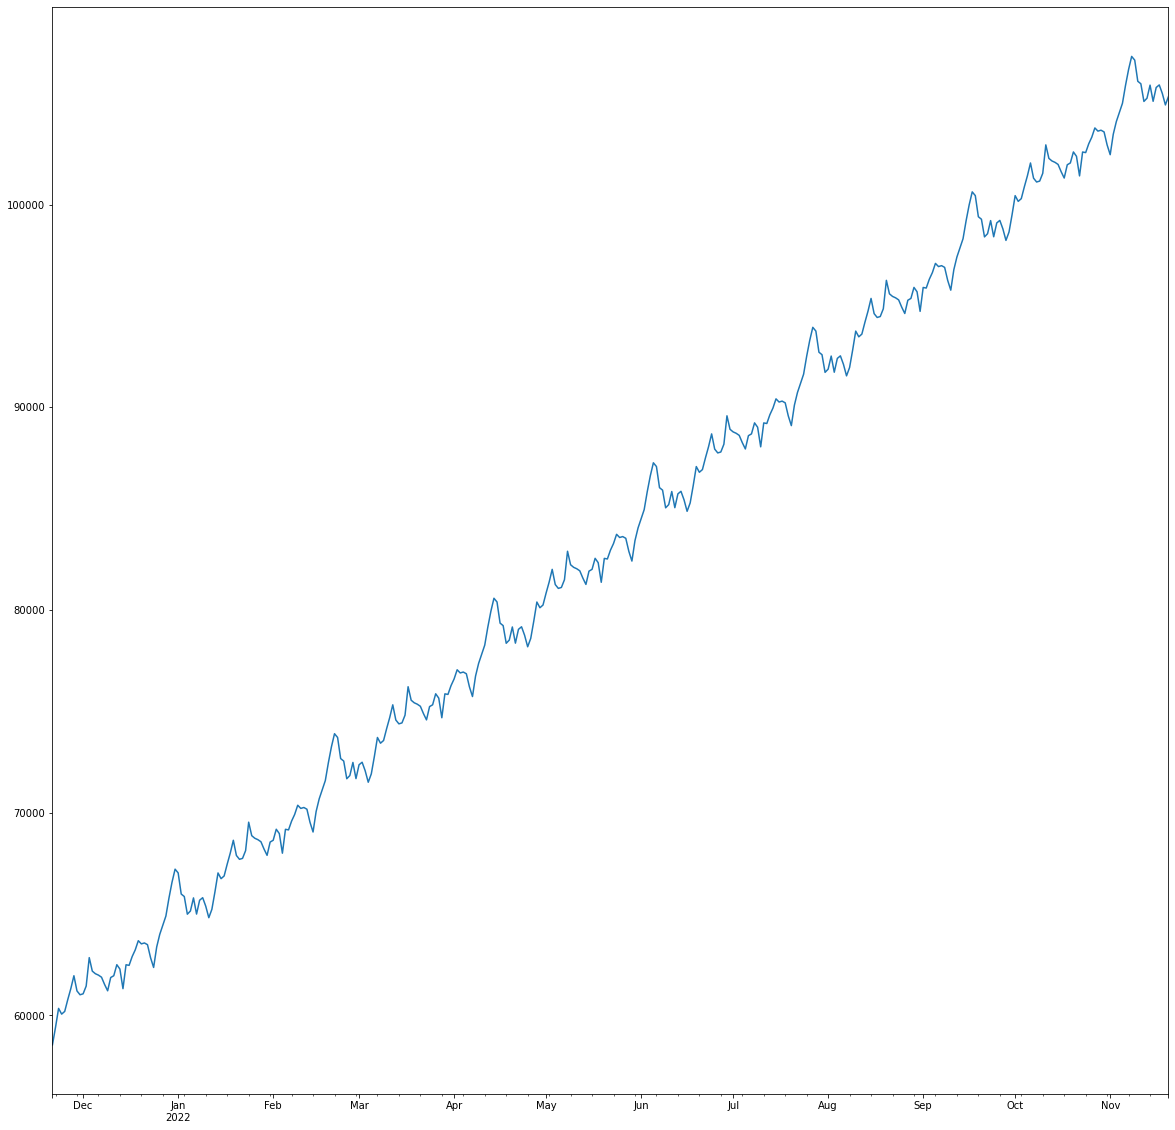

In [27]:
prediction_plot = prediction.plot()

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [16]:
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [17]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue    
        aic = model.aic
        results.append([param, aic])
        print(results, aic)
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 7, dataset['Open'])
result_df

  0%|          | 0/81 [00:00<?, ?it/s]

[[(0, 0, 0, 0), 30350.71141183158]] 30350.71141183158
[[(0, 0, 0, 0), 30350.71141183158], [(0, 0, 0, 1), 29082.16993284101]] 29082.16993284101
[[(0, 0, 0, 0), 30350.71141183158], [(0, 0, 0, 1), 29082.16993284101], [(0, 0, 0, 2), 29079.38608427319]] 29079.38608427319
[[(0, 0, 0, 0), 30350.71141183158], [(0, 0, 0, 1), 29082.16993284101], [(0, 0, 0, 2), 29079.38608427319], [(0, 0, 1, 0), 29751.77041763462]] 29751.77041763462
[[(0, 0, 0, 0), 30350.71141183158], [(0, 0, 0, 1), 29082.16993284101], [(0, 0, 0, 2), 29079.38608427319], [(0, 0, 1, 0), 29751.77041763462], [(0, 0, 1, 1), 29079.150857246117]] 29079.150857246117
[[(0, 0, 0, 0), 30350.71141183158], [(0, 0, 0, 1), 29082.16993284101], [(0, 0, 0, 2), 29079.38608427319], [(0, 0, 1, 0), 29751.77041763462], [(0, 0, 1, 1), 29079.150857246117], [(0, 0, 1, 2), 29071.795656673905]] 29071.795656673905
[[(0, 0, 0, 0), 30350.71141183158], [(0, 0, 0, 1), 29082.16993284101], [(0, 0, 0, 2), 29079.38608427319], [(0, 0, 1, 0), 29751.77041763462], [(0, 

In [23]:
p, q, P, Q = result_df['(p,q)x(P,Q)'][0]

best_model = SARIMAX(dataset['Open'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                               Log_Diff   No. Observations:                 1778
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood                3057.705
Date:                                Sat, 15 Jan 2022   AIC                          -6103.410
Time:                                        15:59:33   BIC                          -6070.537
Sample:                                    01-02-2017   HQIC                         -6091.265
                                         - 11-14-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0356      0.018     -1.991      0.046      -0.071      -0.001
ar.

In [27]:
prediction = best_model.predict(365)

In [28]:
prediction

2018-01-02    0.018087
2018-01-03    0.014278
2018-01-04    0.005969
2018-01-05    0.023545
2018-01-06    0.001273
                ...   
2021-11-10    0.000114
2021-11-11    0.007698
2021-11-12    0.002552
2021-11-13    0.003096
2021-11-14    0.004309
Freq: D, Name: predicted_mean, Length: 1413, dtype: float64

In [ ]:
plt.rcParams.update({'figure.figsize': (20,20)})